# SPACE CHARGE EFFECTS ON THE SHORT PULSE BEAM PROFILE

### Yves HERI

#### Michigan State University

____

This notebook contains code for simulating the dynamics of short-pulse beam profiles within a vacuum diode gap. For detailed information on the simulation parameters, please refer to the paper "[Maximal charge injection of consecutive electron pulses with uniform temporal pulse separation](https://aip.scitation.org/doi/10.1063/1.4928586)" by **Y. L. Liu et al.**.

 While the paper presents results for continuous electron beams, we focus on simulating short-pulse beams with Gaussian and square-top profiles.

If you have any questions, please feel free to contact me.

____

### I. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_context("paper",font_scale = 1.4)
from scipy import constants as cst
import warnings
warnings.filterwarnings("ignore")
import matplotlib.animation as animation

### II. Define the RK4 Solver

In [2]:
def runge_kutta_4(func,XV,rho,t, _dt=1e-6):
    
    f1,E_field = func(XV,rho,t)
    f2,E_field = func(XV + (f1 * (_dt / 2)),rho,t)
    f3,E_field = func(XV + (f2 * (_dt / 2)),rho,t)
    f4,E_field = func(XV + (f3 * _dt),rho,t)
    
    return XV + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4),E_field

### III. Define Simulation Parameters 

In [3]:
Time_CL = lambda Vg,d : 3*d/np.sqrt(2*cst.e*Vg/cst.m_e)

Time_transit = lambda Vg,d : np.sqrt(2*d/(cst.e*Vg/(d*cst.m_e))) 

Sigma_1 = lambda Vg,d : -cst.epsilon_0*Vg/d

Current_density = lambda Vel,S : 3*(S)*Vel.sum(axis=1) 

pulse_length = lambda p: int(p*T0/Dt)  

def sigma_N_1(Vg,N,d,Dt):
    E0=-Vg/d
    return (1/N)*(1/(1-(1/2)*(-cst.e*E0/cst.m_e)*(Dt**2/d)*((N-1)/2)))

def pulse_profile(N,Sigma, Type = 'square',sd = 15):
    Type = Type.lower()
    if Type == 'square':
        return np.ones(N)*Sigma
    if Type == 'gauss':
        X = np.arange(N)
        m = np.mean(X)
        sig = np.sqrt(sd)
        fg = np.exp(-(X-m)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi)) 
        fg = fg/np.max(fg)
        return fg*Sigma
    else:
        return print('Profile not recognized')

### IV. Equations of motion

In [4]:
def Equations_Motion(XV,rho,t):

  count = int(t/D)
  r = int(len(XV)/2) # XV == vel. and pos., dividing by 2 gives len(pos.)

  V = XV[:r] # Velocities vector
  X = XV[r:] # Positions vector

  dv=np.zeros(r)
  dx=np.zeros(r)
  E_f = np.zeros(r)

  if count > r :
    count = r 

  first_sum = 0
  for j in range(count):

    if X[j] >= 1 or X[j] < 0 :
      V[j]=0
    else:
      first_sum += X[j]*rho[j]

    second_sum = 0
    for i in range(j):
      second_sum += rho[i]

    E_f[j] = 1 + (first_sum - (second_sum + rho[j]/2))

    dv[j]=1.5*E_f[j]
    dx[j]= 3*V[j]

  return np.concatenate([dv,dx]),E_f

### V. Parameters

In [5]:
#=========================

Vg = 30e3
d = 1.5e-3
Dt = 1e-13

#=========================

Tcl = Time_CL(Vg,d)
T0 = Time_transit(Vg,d)
N = pulse_length(0.1)
Sigma = sigma_N_1(Vg,N,d,Dt)
D = Dt/Tcl    # Normalized time-step
Dt_b = 0.1*D # Time step RK4

#=========================

time = np.arange(0, 2+ Dt_b, Dt_b)
rho_square = pulse_profile(N,Sigma)
rho_gauss = pulse_profile(N,Sigma,'gauss')

#=========================

### VI. Plots of trajectories

In [6]:
def plots_time(XV_init,rho_profile,plot = True,sim="stop"):

    r = int(len(XV_init)/2)

    state_history = []
    field_history = []
    potential_history = []
    yk = XV_init
    E_field = np.ones(r)
  

    if sim == "stop":
        i = 0
        t = time[i] 
        while (yk[r:] < np.ones(r)).any(): # Stop simulation when all sheets reach the anode
            state_history.append(yk)
            field_history.append(E_field)
            yk,E_field = runge_kutta_4(Equations_Motion,yk,rho_profile,t, Dt_b)
            i +=1
            t = time[i]

    if sim == "n_stop":
        for t in time:
            state_history.append(yk)
            field_history.append(E_field)
            yk,E_field = runge_kutta_4(Equations_Motion,yk,rho_profile,t, Dt_b)
  


    state_history = np.array(state_history)
    field_history = np.array(field_history)

    position = state_history[:,r:]
    velocity = state_history[:,:r]

    J = Current_density(velocity,Sigma)

    r_new = len(position)

    if plot:

        plt.figure(figsize=(6,3))
        for i in range(r):
      
            plt.subplot(1,2,1)
            plt.plot(time[:r_new], position[:, i],"black",lw=2.5)
            plt.xlim(0,2)
            plt.ylim(0,1)
            plt.ylabel("Position")
            plt.xlabel("Time")
            plt.title("Position")

            plt.subplot(1,2,2)
            plt.plot(time[:r_new],J)
            plt.xlim(0,2)
            plt.ylabel("J")
            plt.xlabel("Time")
            plt.title("Current density")

            plt.tight_layout(pad=2)

    # plt.savefig('figure.png',transparent=True)

    return position,velocity,field_history

### VII. Plots of snapshots of the beam profile and Phase-space trajectories

In [7]:
def plots_shape_phase(position,velocity,E_field,rho,n=3):

    lag = int(len(position)/n)

    for i in range(n):
        plt.figure(figsize=(9,3))

        shape = np.array([position[lag*i],rho])
        field = np.array([position[lag*i],E_field[lag*i]])
        phase = np.array([position[lag*i],velocity[lag*i]])

        plt.subplot(1,3,1)
        plt.title("Pulse profile")
        plt.plot(shape[0],shape[1],lw=3)
        plt.xlabel("Position")
        plt.ylabel("Charge")
        plt.xlim(0,1)

        plt.subplot(1,3,2)
        plt.title("E field")
        plt.plot(field[0],field[1],lw=3)
        plt.xlabel("Position")
        plt.ylabel("E")
        plt.xlim(0,1)

        plt.subplot(1,3,3)
        plt.title("Phase-space profile")
        plt.plot(phase[0],phase[1],lw=3)
        plt.xlabel("Position")
        plt.ylabel("Velocity")
        plt.xlim(0,1)

        plt.tight_layout(pad=2)

        plt.show()

### Plots for comparison

In [8]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=3):

    lag = int(len(position[0])/n)

    len_rho = len(rho) 

    for i in range(n+1):

        if i == n:

            lag = lag - 1

        plt.figure(figsize=(9,3))

        for j in range(len_rho):
            
            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=3)
            plt.xlabel("Position")
            plt.ylabel("Charge")
            plt.xlim(0,1)

            plt.subplot(1,3,2)
            plt.title("E field")
            plt.plot(field[0],field[1],lw=3)
            plt.xlabel("Position")
            plt.ylabel("E")
            plt.xlim(0,1)

            plt.subplot(1,3,3)
            plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=3)
            plt.xlabel("Position")
            plt.ylabel("Velocity")
            plt.xlim(0,1)

            plt.tight_layout(pad=2)

    plt.show()

### Distorsion 

In [9]:
def distorsion(position,time):

    n = len(position)

    T1 = 0
    T2 = 0

    for i in range(n):

        if T1 != 0 :
            pass
        else:
            if position[i,-1] >= 1:
                T1 = time[i]

        if T2 != 0 :
            pass
        else:
            if position[i,-2] >= 1:
                T2 = time[i]
                
    return abs(T2-T1)

 # 1. Non-preloaded sheets

In [10]:
XV0 = np.zeros(2*N) # Intial conditions

## 1.1 Square-top profile

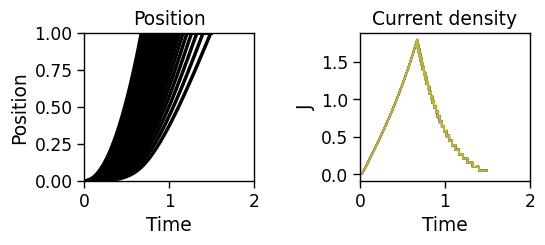

In [11]:
position_sq,velocity_sq,E_field_sq = plots_time(XV0,rho_square)

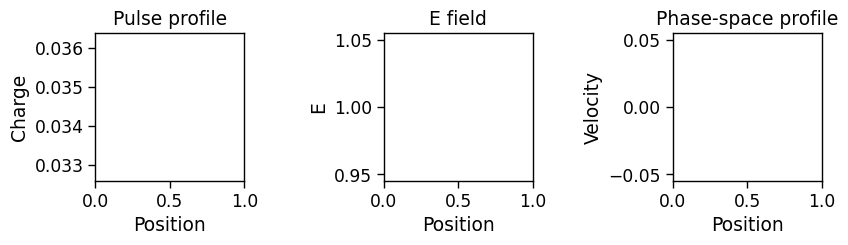

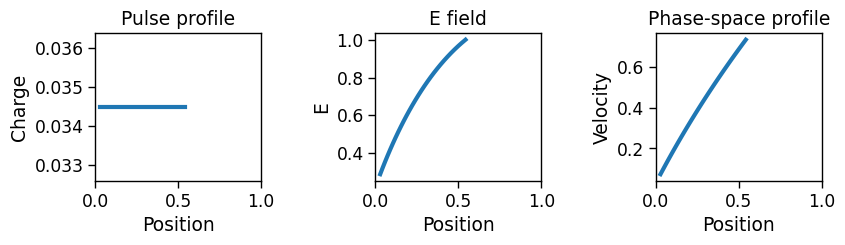

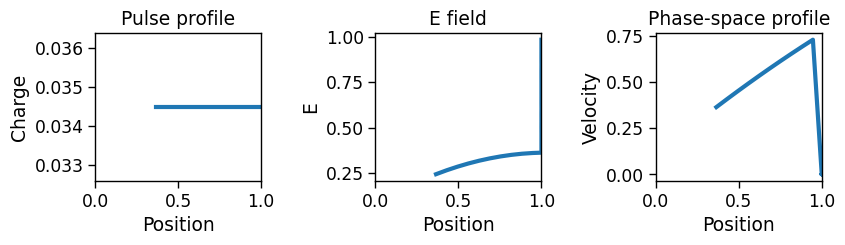

In [12]:
plots_shape_phase(position_sq,velocity_sq,E_field_sq,rho_square)

## 1.2 Gaussian profile

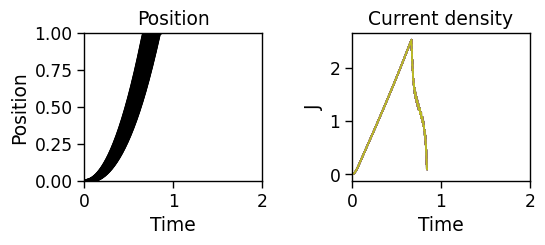

In [13]:
position_g,velocity_g,E_field_g = plots_time(XV0,rho_gauss)

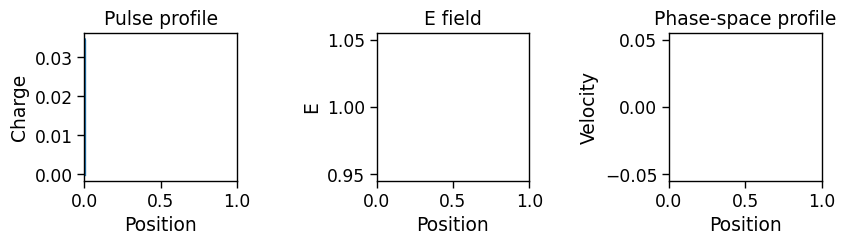

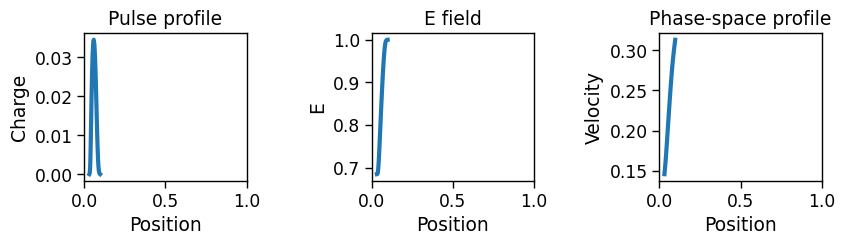

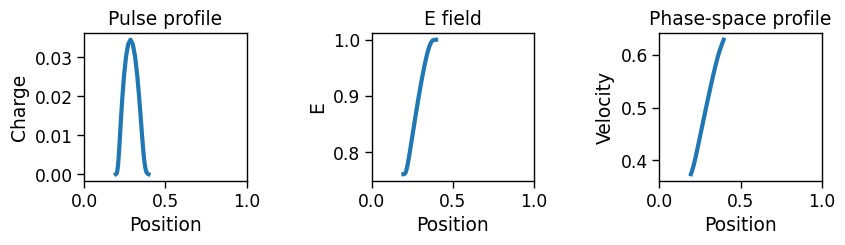

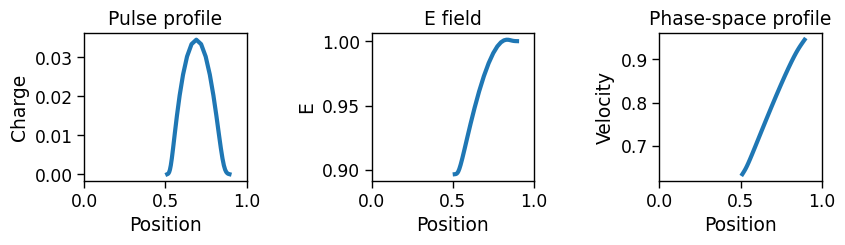

In [14]:
plots_shape_phase(position_g,velocity_g,E_field_g,rho_gauss,4)

 # 2. Preloaded sheets

In [15]:
XV0 = np.zeros(2*N) # Initial conditions
for i in range(N):
    XV0[i+N] = (N-i)*D

 ## *2.1. Square-top profile*

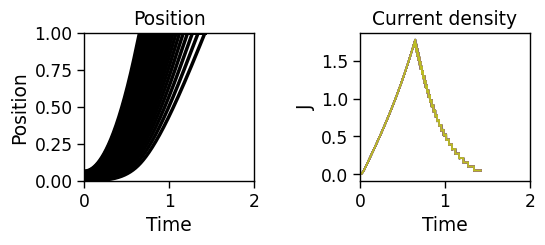

In [16]:
position_sq,velocity_sq,E_field_sq = plots_time(XV0,rho_square)

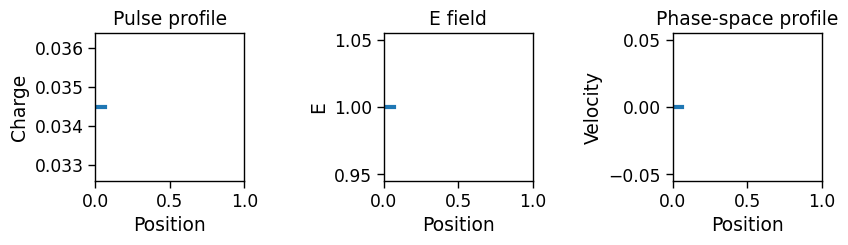

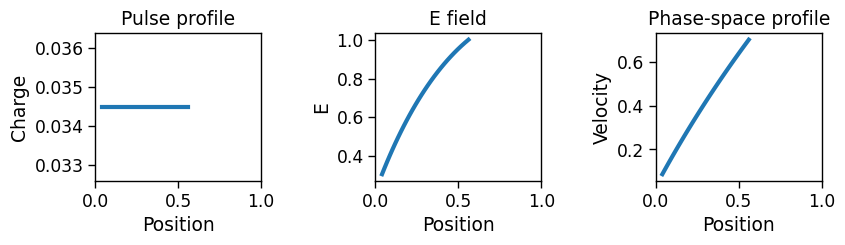

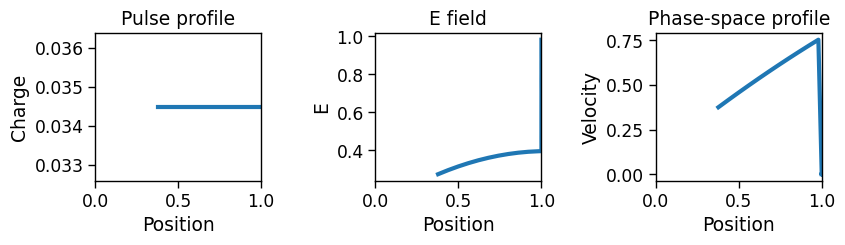

In [17]:
plots_shape_phase(position_sq,velocity_sq,E_field_sq,rho_square)

## *2.2 Gaussian profile*

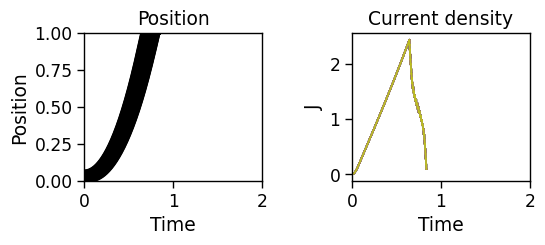

In [18]:
position_g,velocity_g,E_field_g = plots_time(XV0,rho_gauss)

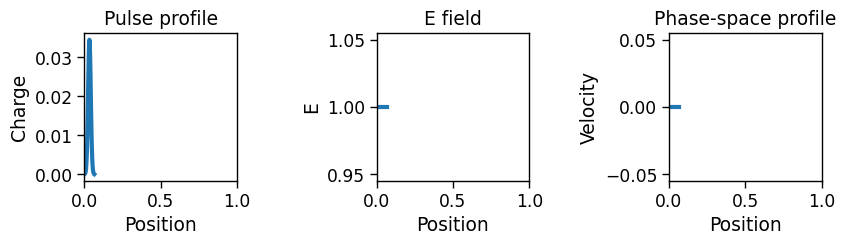

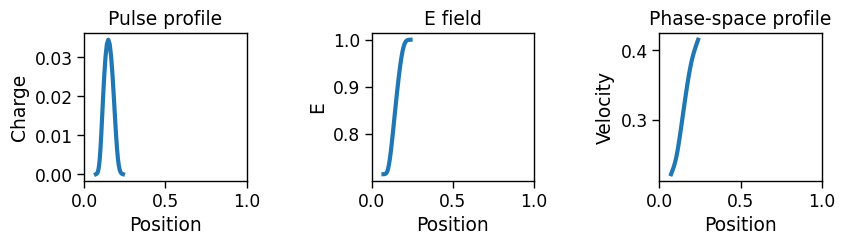

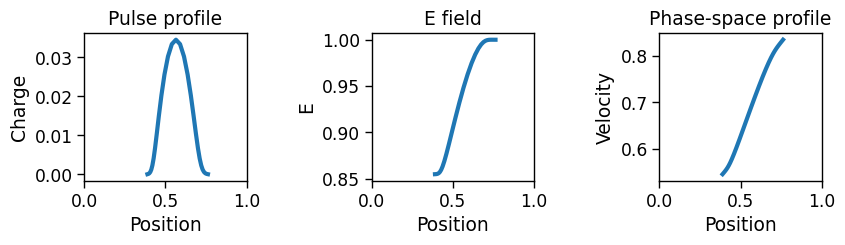

In [19]:
plots_shape_phase(position_g,velocity_g,E_field_g,rho_gauss)

### Gaussian Profile evolution inside the Gap

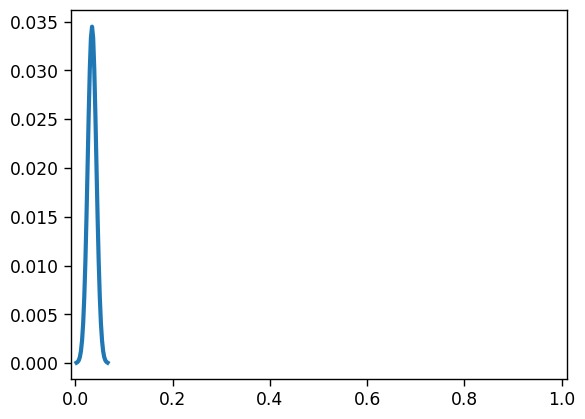

In [20]:
shape = np.array([position_g[0],rho_gauss])
    
fig, ax = plt.subplots()

plt.xlim(-0.01,1.01)

line, = ax.plot(shape[0],shape[1],lw=3)

def animate(i):
    shape = np.array([position_g[12*i],rho_gauss])
    line.set_data(shape[0],shape[1])  # update the data
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 305),interval=50, blit=True)

plt.show()

from IPython.display import HTML
HTML(ani.to_html5_video())

# 3. Gaussian profiles comparison

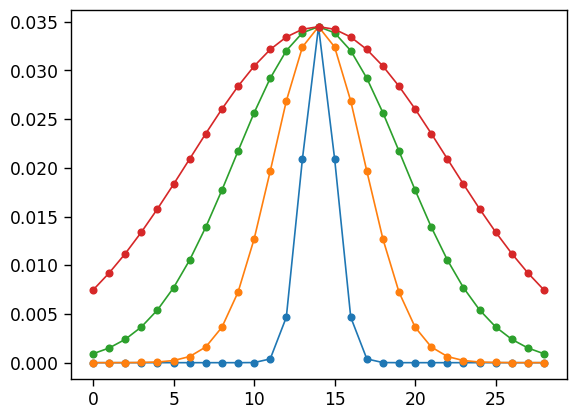

In [21]:
rho_gauss_mult = []
for i in range(1,5):
    rho_gauss_mult.append(pulse_profile(N,Sigma,'gauss',(i**3)))
rho_gauss_mult = np.array(rho_gauss_mult)

for i in range(4):
    plt.plot(rho_gauss_mult[i],'o-')

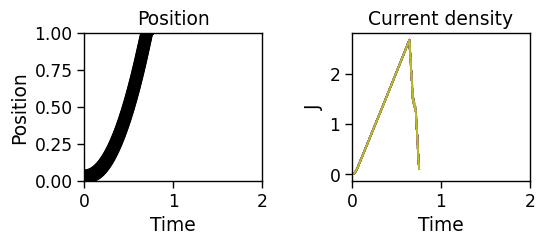

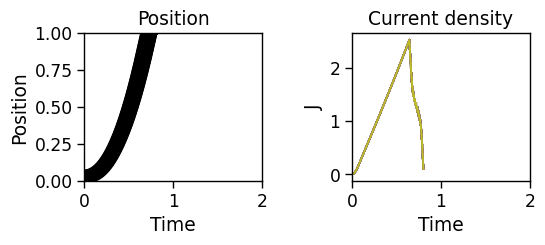

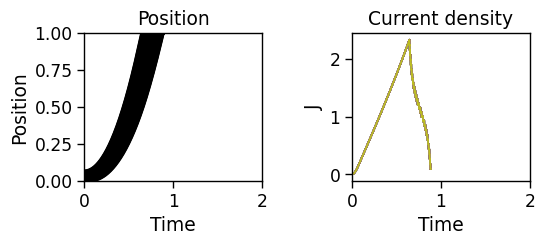

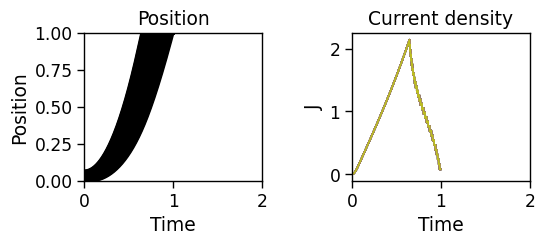

In [22]:
position_g_mult = []
velocity_g_mult = []
E_field_g_mult = []

for i in range(4):

    res_ = plots_time(XV0,rho_gauss_mult[i])
    # plt.show()
    position_g_mult.append(res_[0])
    velocity_g_mult.append(res_[1])
    E_field_g_mult.append(res_[2])

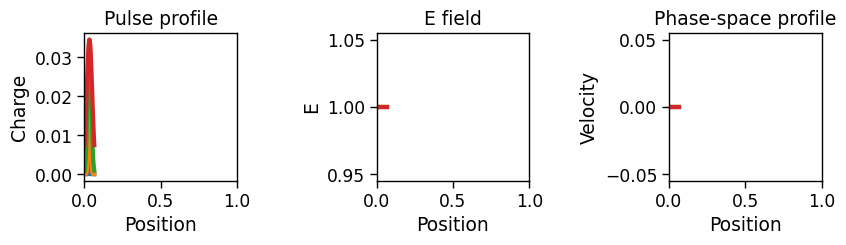

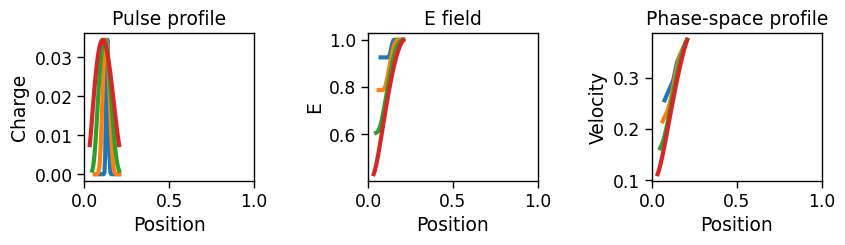

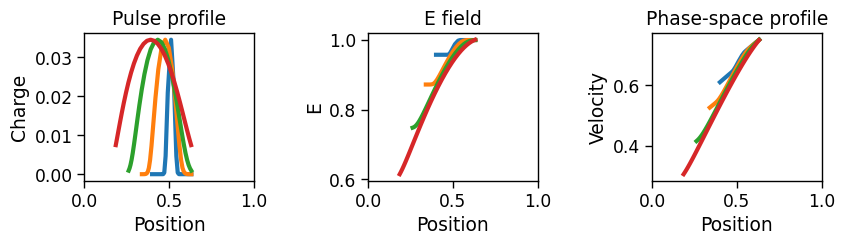

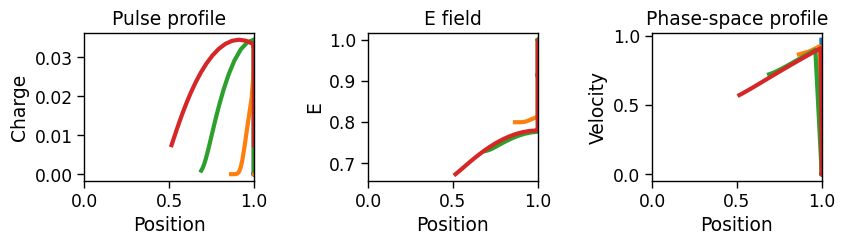

In [23]:
plots_shape_phase_mult(position_g_mult,velocity_g_mult,E_field_g_mult,rho_gauss_mult)

# 4. Scaling

In [24]:
f_range = np.linspace(0.1,1,10)

# f_range

### Square-top Profiles

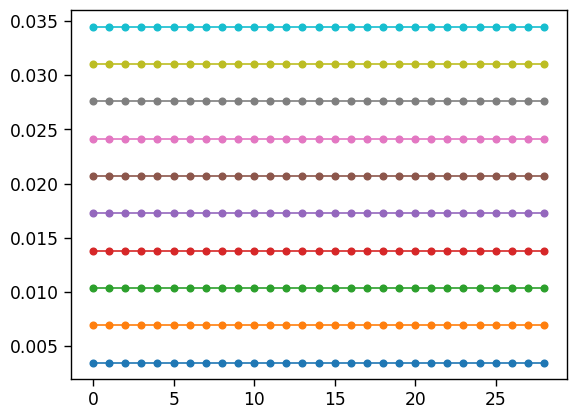

In [25]:
rho_sq_scale = []
for f in f_range:
    rho_sq_scale.append(pulse_profile(N,(f)*Sigma))
rho_sq_scale = np.array(rho_sq_scale)

for i in range(len(f_range)):
    plt.plot(rho_sq_scale[i],'o-')


### Simulation

In [26]:
position_sq_scale = []
velocity_sq_scale = []
E_field_sq_scale = []

for i in range(len(f_range)):

    res_ = plots_time(XV0,rho_sq_scale[i],plot = False, sim = "n_stop")
    # plt.show()
    position_sq_scale.append(res_[0])
    velocity_sq_scale.append(res_[1])
    E_field_sq_scale.append(res_[2])

### Distorsion scaling with charge for Square-top profiles

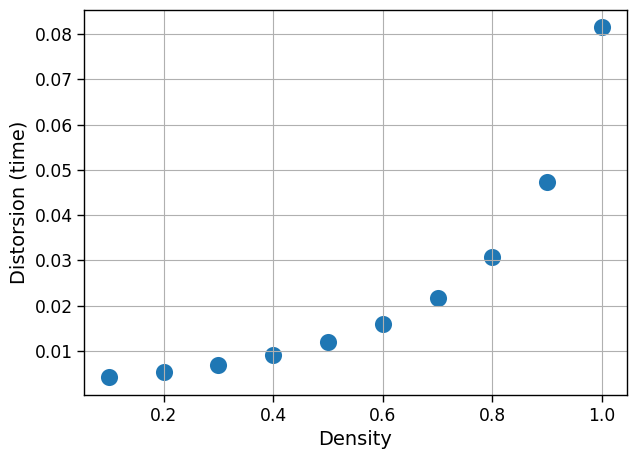

In [27]:
distorsion_list_sq = []
position_sq_scale =np.array(position_sq_scale)

for i in range(len(f_range)):
    distorsion_list_sq.append(distorsion(position_sq_scale[i],time))
distorsion_list_sq = np.array(distorsion_list_sq)

figure(figsize=(7, 5), dpi=100)
plt.scatter(f_range,distorsion_list_sq,lw=7.5)
plt.ylabel('Distorsion (time)', fontsize=14)
plt.xlabel('Density', fontsize=14)
plt.grid()

### Gaussian Profiles

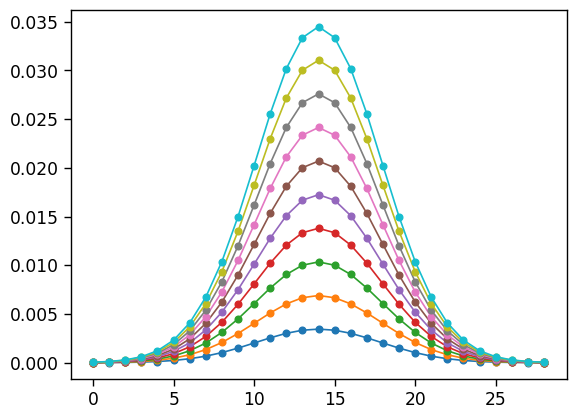

In [28]:
rho_gauss_scale = []

for f in f_range:
    rho_gauss_scale.append(pulse_profile(N,(f)*Sigma,'gauss'))
rho_gauss_scale = np.array(rho_gauss_scale)

for i in range(len(f_range)):
  plt.plot(rho_gauss_scale[i],'o-')


### Simulation

In [29]:
position_g_scale = []
velocity_g_scale = []
E_field_g_scale = []

for i in range(len(f_range)):

    res_ = plots_time(XV0,rho_gauss_scale[i],plot = False, sim = "stop")
    # plt.show()
    position_g_scale.append(res_[0])
    velocity_g_scale.append(res_[1])
    E_field_g_scale.append(res_[2])

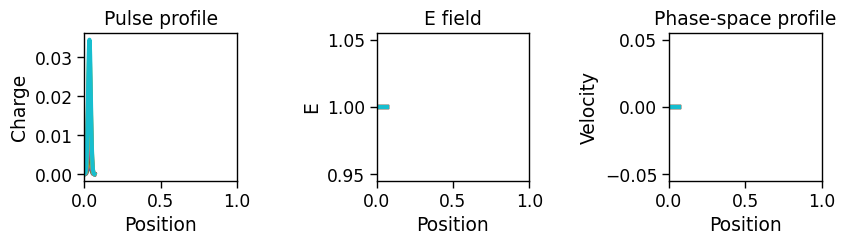

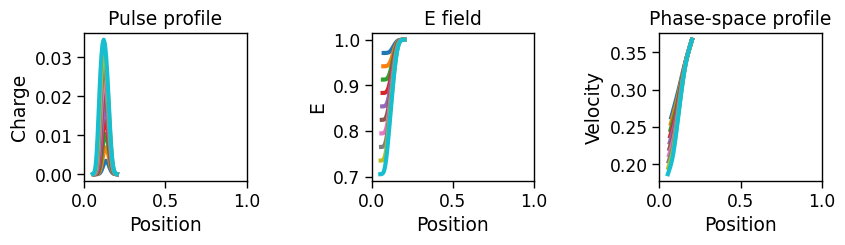

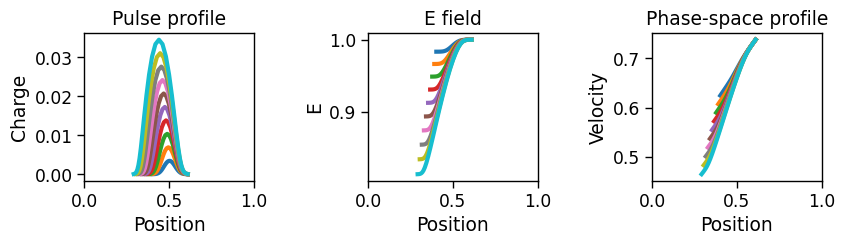

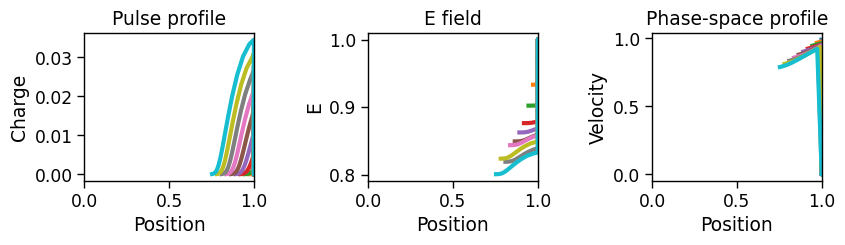

In [30]:
plots_shape_phase_mult(position_g_scale,velocity_g_scale,E_field_g_scale,rho_gauss_scale)

### Distorsion scaling with charge for Gaussian Profiles

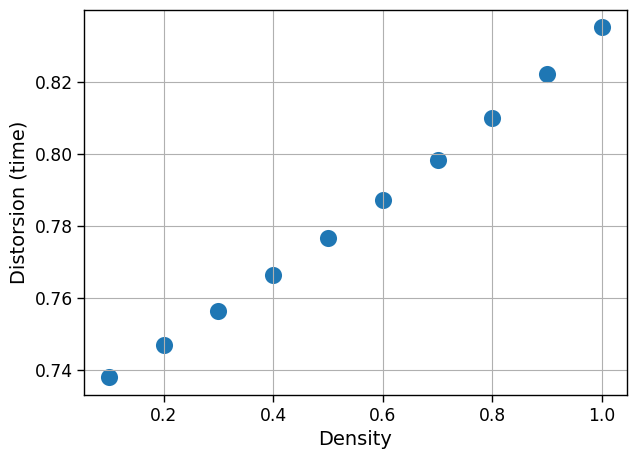

In [31]:
distorsion_list_g = []
position_g_scale =np.array(position_g_scale)

for i in range(len(f_range)):
    distorsion_list_g.append(distorsion(position_g_scale[i],time))
distorsion_list_g = np.array(distorsion_list_g)

figure(figsize=(7, 5), dpi=100)
plt.scatter(f_range,distorsion_list_g,lw=7.5)
plt.ylabel('Distorsion (time)', fontsize=14)
plt.xlabel('Density', fontsize=14)
plt.grid()

___